In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import base
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import re
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical as one_hot
import tensorflow_decision_forests as tfdf
from sklearn.preprocessing import OrdinalEncoder
sns.set()

2023-05-28 14:15:10.625044: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [95]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
y = train['Survived']
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<Axes: xlabel='Survived', ylabel='Count'>

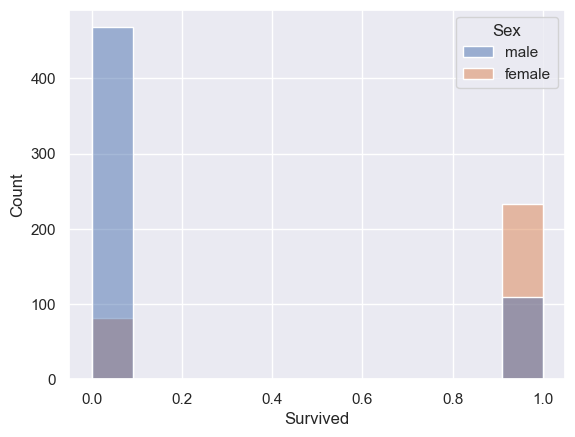

In [96]:
sns.histplot(train, x="Survived", hue="Sex")

<Axes: xlabel='Age', ylabel='Count'>

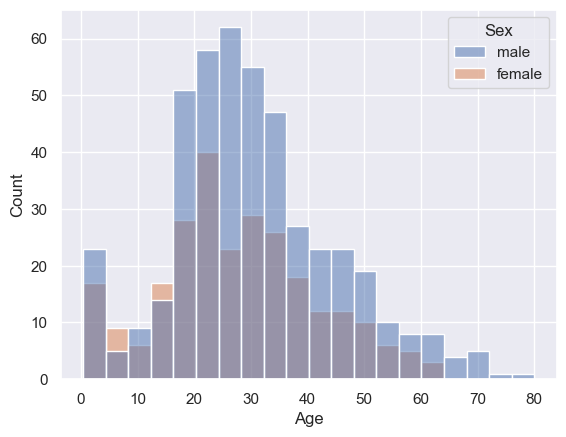

In [97]:
sns.histplot(train, x="Age", hue="Sex")

In [192]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [178]:
class addFeatures(base.BaseEstimator, base.TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        cabin = X['Cabin'].fillna('0')
        num_cabins = [len(g.split(' ')) if g != '0' else 0 for g in cabin]
        X['num_cabins'] = num_cabins
        
        child = [1 if a < 13 else 0 for a in X['Age']]
        X['child'] = child
        
        return X

In [179]:
#cabin_split = [list(filter(None, re.split('(\d+)', i))) for i in cabin]
#cabin_group = [g[0] if g[0] != '0' else np.nan for g in cabin_split]
#cabin_number = [int(g[-1]) if len(g) > 1 else 0 for g in cabin_split]

#train['cabin_group'] = cabin_group
#train['cabin_number'] = cabin_number

In [180]:
add_features = addFeatures()

In [205]:
numerical_cols = ['Fare', 'Age', 'SibSp', 'Parch', 'num_cabins']
categorical_cols = ['Pclass', 'Sex', 'child']

In [206]:
numerical_transformer = SimpleImputer(strategy='median')

In [207]:
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [208]:
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [209]:
pipeline = Pipeline([
    ('addFeatures', add_features),
    ('preprocessor', preprocessor),
    #('model', LogisticRegression(max_iter=1000, C=0.1))
    #('model', RidgeClassifier(alpha=0.1))
    ('model', RandomForestClassifier(random_state=0, n_estimators=500, max_depth=10))
])

In [210]:
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.25, random_state=42)

In [211]:
#model = LogisticRegression(max_iter=1000, C=0.1)
#model = RidgeClassifier(alpha=0.1)
#model.fit(x_train, y_train)

In [212]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('addFeatures', addFeatures()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Fare', 'Age', 'SibSp',
                                                   'Parch', 'num_cabins']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex',
                                                   'child'])])),
                ('model',
                 RandomForestClassifier(max_depth=10, n_estimators=500,
                                        random_state=0))])

In [213]:
predictions = pipeline.predict(x_test)

In [214]:
print(accuracy_score(y_test, predictions))

0.8116591928251121


In [255]:
wrong = [i for i, v in enumerate(y_test) if v != predictions[i]]
x_wrong = x_test.iloc[wrong].copy()
x_wrong['prediction'] = predictions[wrong]
x_wrong[x_wrong['Fare'] <= 10][x_wrong['Pclass'] == 3]

/var/folders/n8/mc27w99j19q1kx20z133q0w40000gp/T/ipykernel_3099/1594585705.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_wrong[x_wrong['Fare'] <= 10][x_wrong['Pclass'] == 3]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,prediction
192,193,1,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.0,1,0,350046,7.8542,NaN,S,0
396,397,0,3,"Olsson, Miss. Elina",female,31.0,0,0,350407,7.8542,NaN,S,1
235,236,0,3,"Harknett, Miss. Alice Phoebe",female,NaN,0,0,W./C. 6609,7.5500,NaN,S,1
204,205,1,3,"Cohen, Mr. Gurshon ""Gus""",male,18.0,0,0,A/5 3540,8.0500,NaN,S,0
44,45,1,3,"Devaney, Miss. Margaret Delia",female,19.0,0,0,330958,7.8792,NaN,Q,0
767,768,0,3,"Mangan, Miss. Mary",female,30.5,0,0,364850,7.7500,NaN,Q,1
338,339,1,3,"Dahl, Mr. Karl Edwart",male,45.0,0,0,7598,8.0500,NaN,S,0
286,287,1,3,"de Mulder, Mr. Theodore",male,30.0,0,0,345774,9.5000,NaN,S,0
81,82,1,3,"Sheerlinck, Mr. Jan Baptist",male,29.0,0,0,345779,9.5000,NaN,S,0
534,535,0,3,"Cacic, Miss. Marija",female,30.0,0,0,315084,8.6625,NaN,S,1


/var/folders/n8/mc27w99j19q1kx20z133q0w40000gp/T/ipykernel_3099/3156316609.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(x_wrong[x_wrong['Fare'] <= 30][x_wrong['Pclass'] == 3], x="Fare")


<Axes: xlabel='Fare', ylabel='Count'>

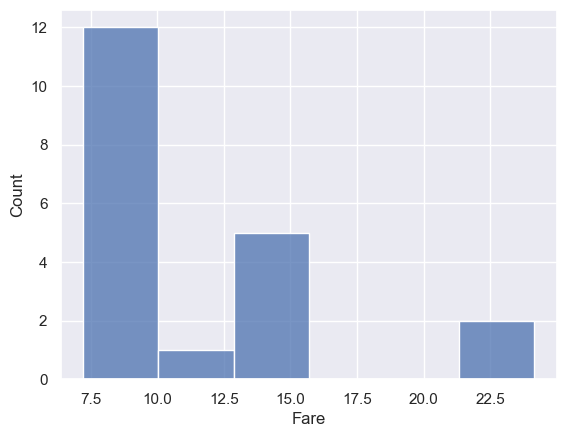

In [253]:
sns.histplot(x_wrong[x_wrong['Fare'] <= 30][x_wrong['Pclass'] == 3], x="Fare")

In [215]:
%%time
scores = cross_val_score(pipeline, train, y, cv=5)
scores.mean()

CPU times: user 4.8 s, sys: 59.2 ms, total: 4.86 s
Wall time: 4.87 s


0.8305567760969179

In [951]:
#params = {'C': [0.1, 1.0, 10.0]}
params = {'model__n_estimators': [100,500,1000], 'model__max_depth': [5,10,20]}

In [952]:
grid = GridSearchCV(pipeline,
                      param_grid=params,
                      n_jobs=-1,
                      verbose = 3)

In [954]:
%%time
grid.fit(x_train, y_train)
grid.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
CPU times: user 1.08 s, sys: 124 ms, total: 1.2 s
Wall time: 14.3 s


{'model__max_depth': 10, 'model__n_estimators': 500}

In [148]:
len(test.PassengerId)

418

In [149]:
final_predictions = pipeline.predict(test)
submission = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': final_predictions})

In [150]:
submission.to_csv('submission.csv', index=False)